In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import healpy as hp
import pyccl as ccl
from scipy import optimize
import tqdm
import sacc
#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
d2r=np.pi/180

Using CAMB 1.3.2 installed at /global/common/software/lsst/common/miniconda/prod/envs/desc/lib/python3.8/site-packages/camb


In [2]:
from scipy.optimize import differential_evolution
# the following commands make plots look better
# try to experiment with these parameters to see what they do
dpi = 300
plt.rcParams['figure.dpi']= dpi
plt.rc("savefig", dpi=dpi)
plt.rc('font', size=10)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)
plt.rc('lines', dotted_pattern = [2., 2.]) # this makes lines plotted by plt.grid much nicer looking
#if you don't have LaTeX installed on your laptop and this statement 
# generates error, comment it out
#plt.rc('text', usetex=True)

In [3]:
ell = np.arange(2,5001)

# read computed correlations from camb
cl_camb = np.load('cl_camb_nonlin.npy',allow_pickle=True).item()
clnn = {}
n = 5
for i in range(1, n+1):
    for j in range(1, n+1):
        clnn[(i,j)] = cl_camb[f'W{i}xW{j}'][2:5001]*2*np.pi/(ell*(ell+1))
        clnn[(j,i)] = cl_camb[f'W{i}xW{j}'][2:5001]*2*np.pi/(ell*(ell+1))

for i in range(1, n+1):
    clnn[6,i] = cl_camb[f'W{i}xP'][2:5001]*np.sqrt(2*np.pi/(ell*(ell+1)))*np.sqrt(np.pi/2)
    clnn[i,6] = cl_camb[f'W{i}xP'][2:5001]*np.sqrt(2*np.pi/(ell*(ell+1)))*np.sqrt(np.pi/2)

clnn[6,6] = cl_camb['PxP'][2:5001]*np.pi/2

# compute T_ij
n=6
Ts = {}
for i in range(1,n+1):
    for j in range(1,i+1):
        Ts[i,j] = np.zeros_like(ell)
        if i==j:
            Ts[i,j]=np.copy(clnn[j,i])
            for k in range(1,j):
                Ts[i,j] -= np.copy(Ts[i,k])**2
            Ts[i,j] = np.sqrt(Ts[i,j])
        if i>j:
            Ts[i,j] = np.copy(clnn[j,i])
            for k in range(1,j):
                Ts[i,j] -= np.copy(Ts[i,k])*np.copy(Ts[j,k])
            Ts[i,j] = np.copy(Ts[i,j])/np.copy(Ts[j,j])

generate correlated alm for N and K maps

In [4]:
n = 5
np.random.seed()
seeds = [np.random.randint(2**31) for i in range(n+1)]

# make random alm with cl=1
alms_rand = {}
for i in range(1,n+2):
    np.random.seed(seeds[i-1])
    alms_rand[i] = hp.synalm(np.concatenate((np.array([0,0]),ell))*0+1)

# generate correlated alms for N and K maps
alms = {}
for i in range(1,n+2):
    alms[i] = 0
    for j in range(1,i+1):
        alms[i] += hp.almxfl(alms_rand[j],np.concatenate((np.array([0,0]),Ts[i,j])))

compute powerspectra from the correlated alms generated above

In [5]:
kk_dict = {'kk':hp.alm2cl(alms[6])[2:5001]}
nk_dict = {}
nn_dict = {}
for i in range(0,n):
    nk_dict[f'n{i}k'] = hp.alm2cl(alms[i+1],alms[6])[2:5001] #*np.sqrt(np.pi/2)*(2*np.pi)**0.5/(ell*(ell+1))**0.5
    for j in range(0,n):
        nn_dict[f'n{i}n{j}'] = hp.alm2cl(alms[i+1],alms[j+1])[2:5001]#*2*np.pi/(ell*(ell+1))

check the NN self power spectra

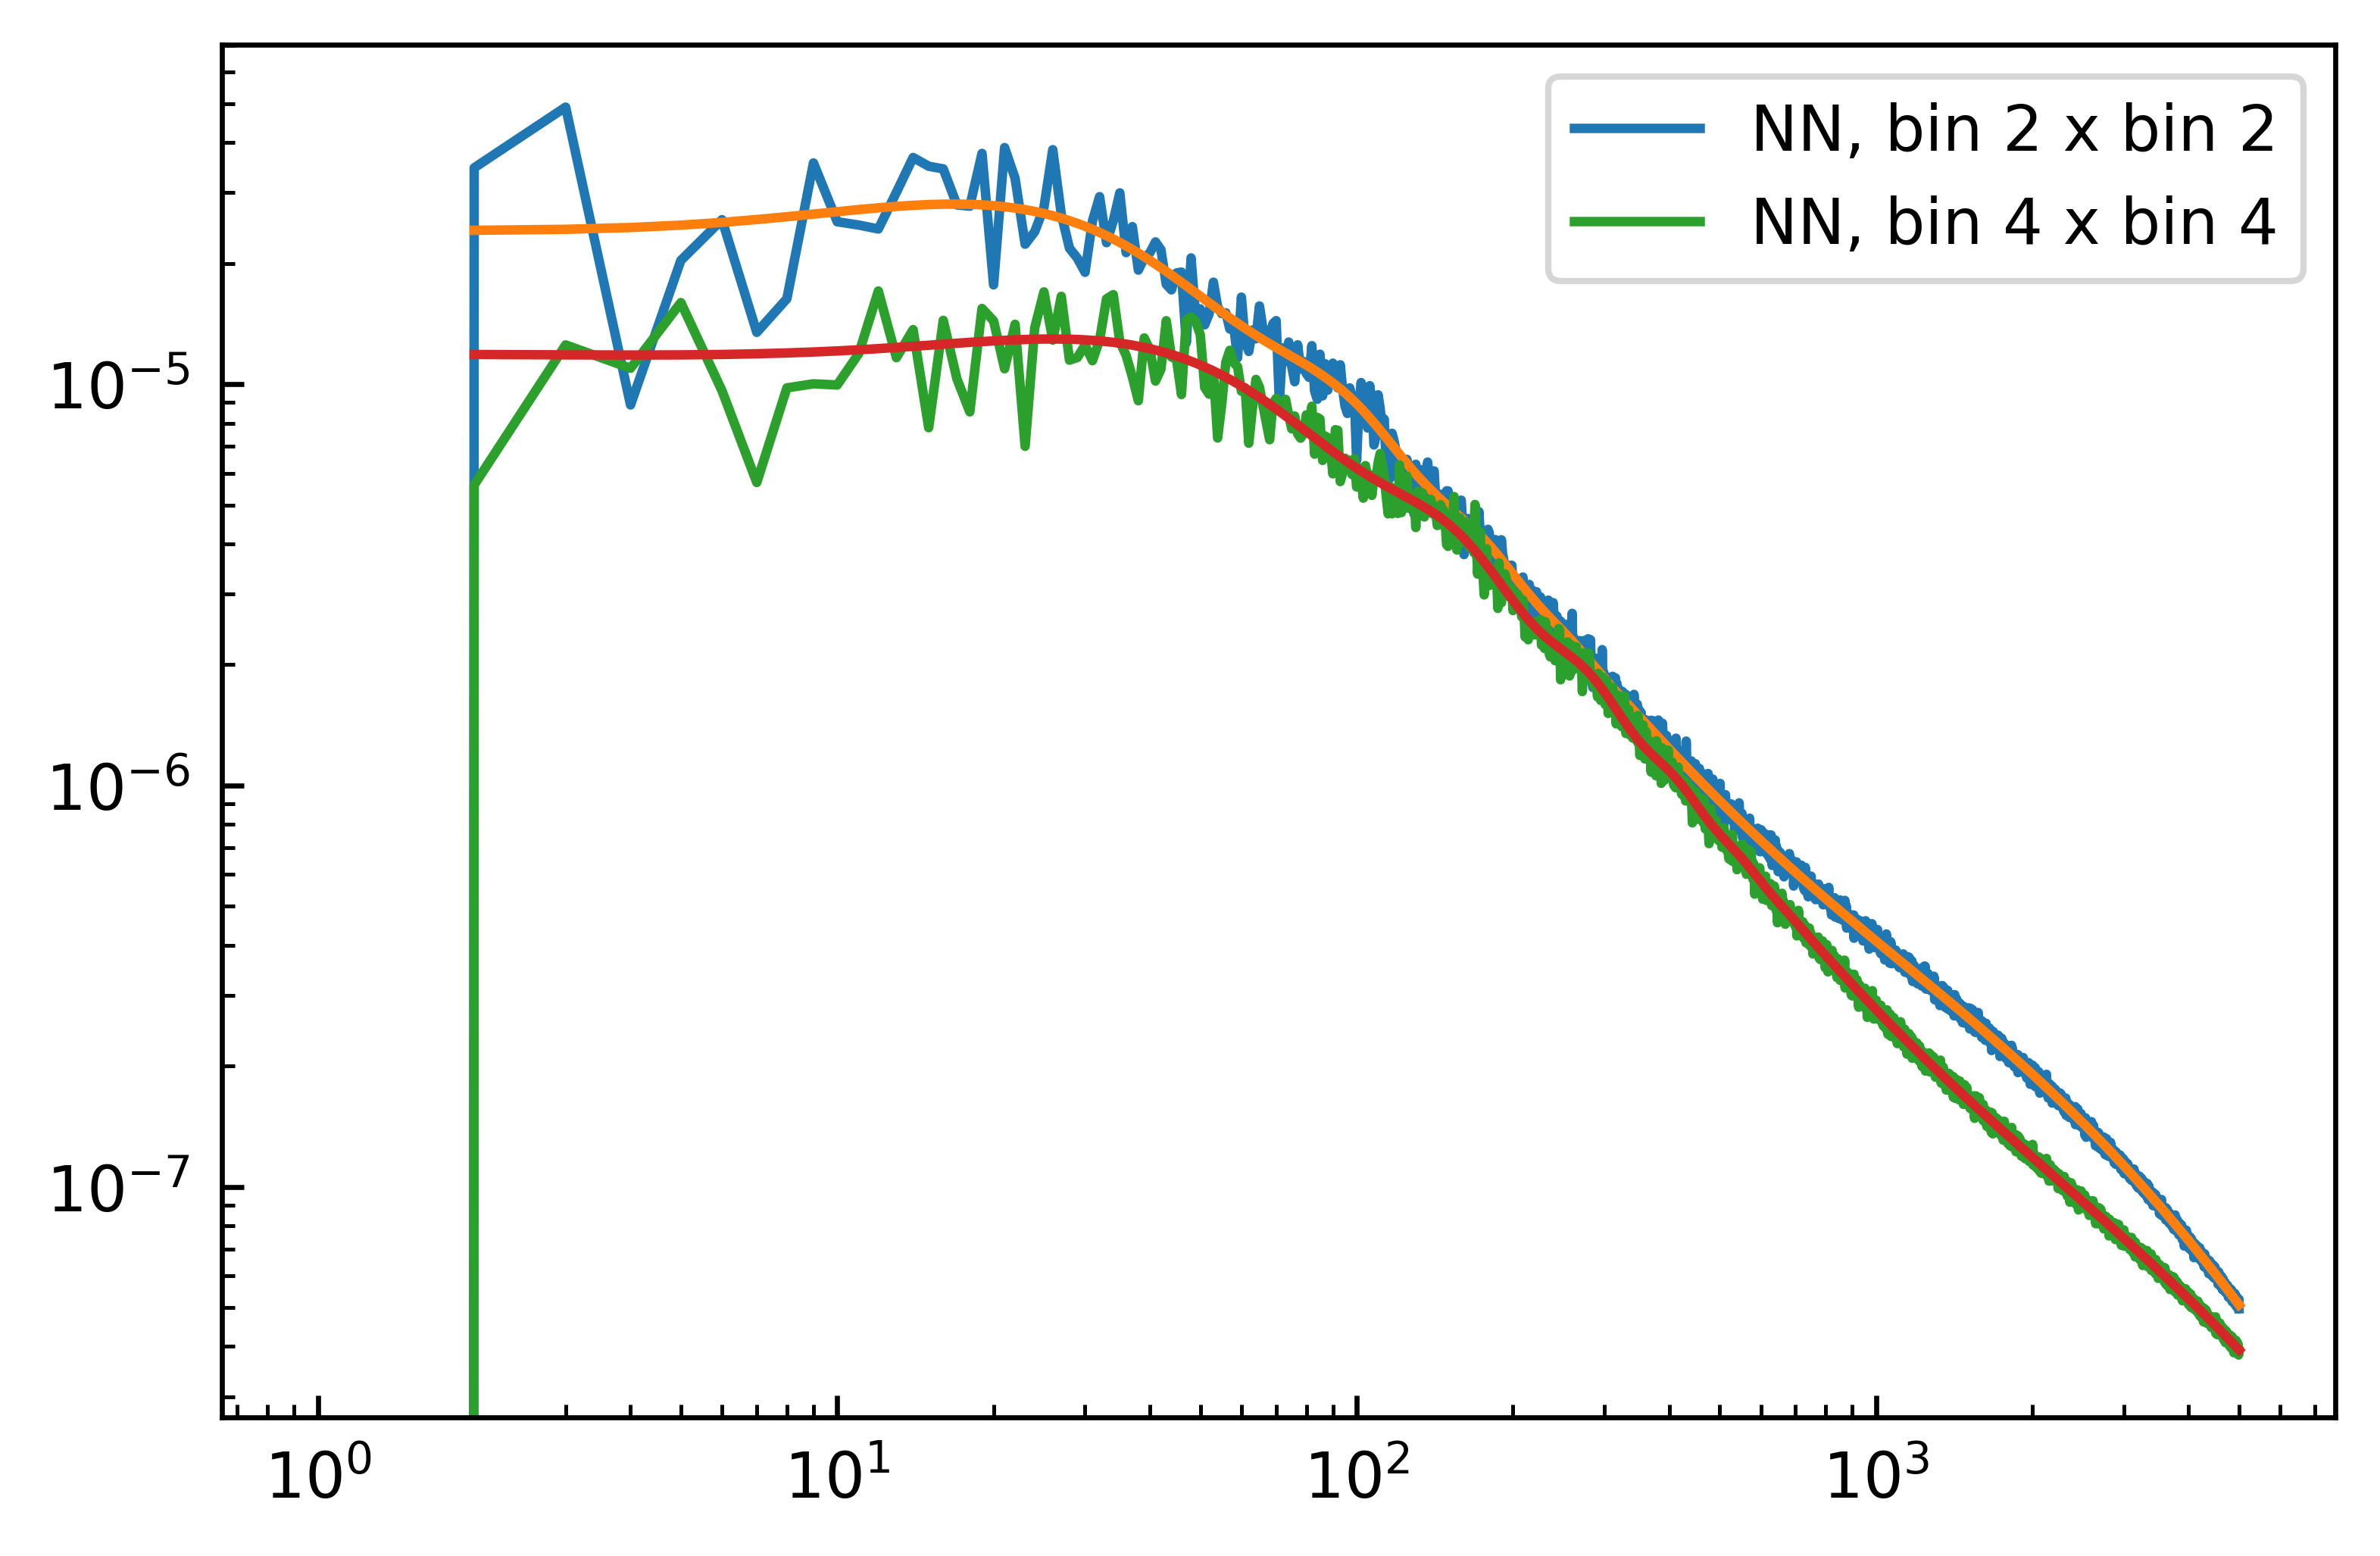

In [6]:
plt.loglog(hp.alm2cl(alms[2]),label='NN, bin 2 x bin 2')
plt.loglog(ell,clnn[2,2])

plt.loglog(hp.alm2cl(alms[4]),label='NN, bin 4 x bin 4')
plt.loglog(ell,clnn[4,4])
plt.legend()

Check KK

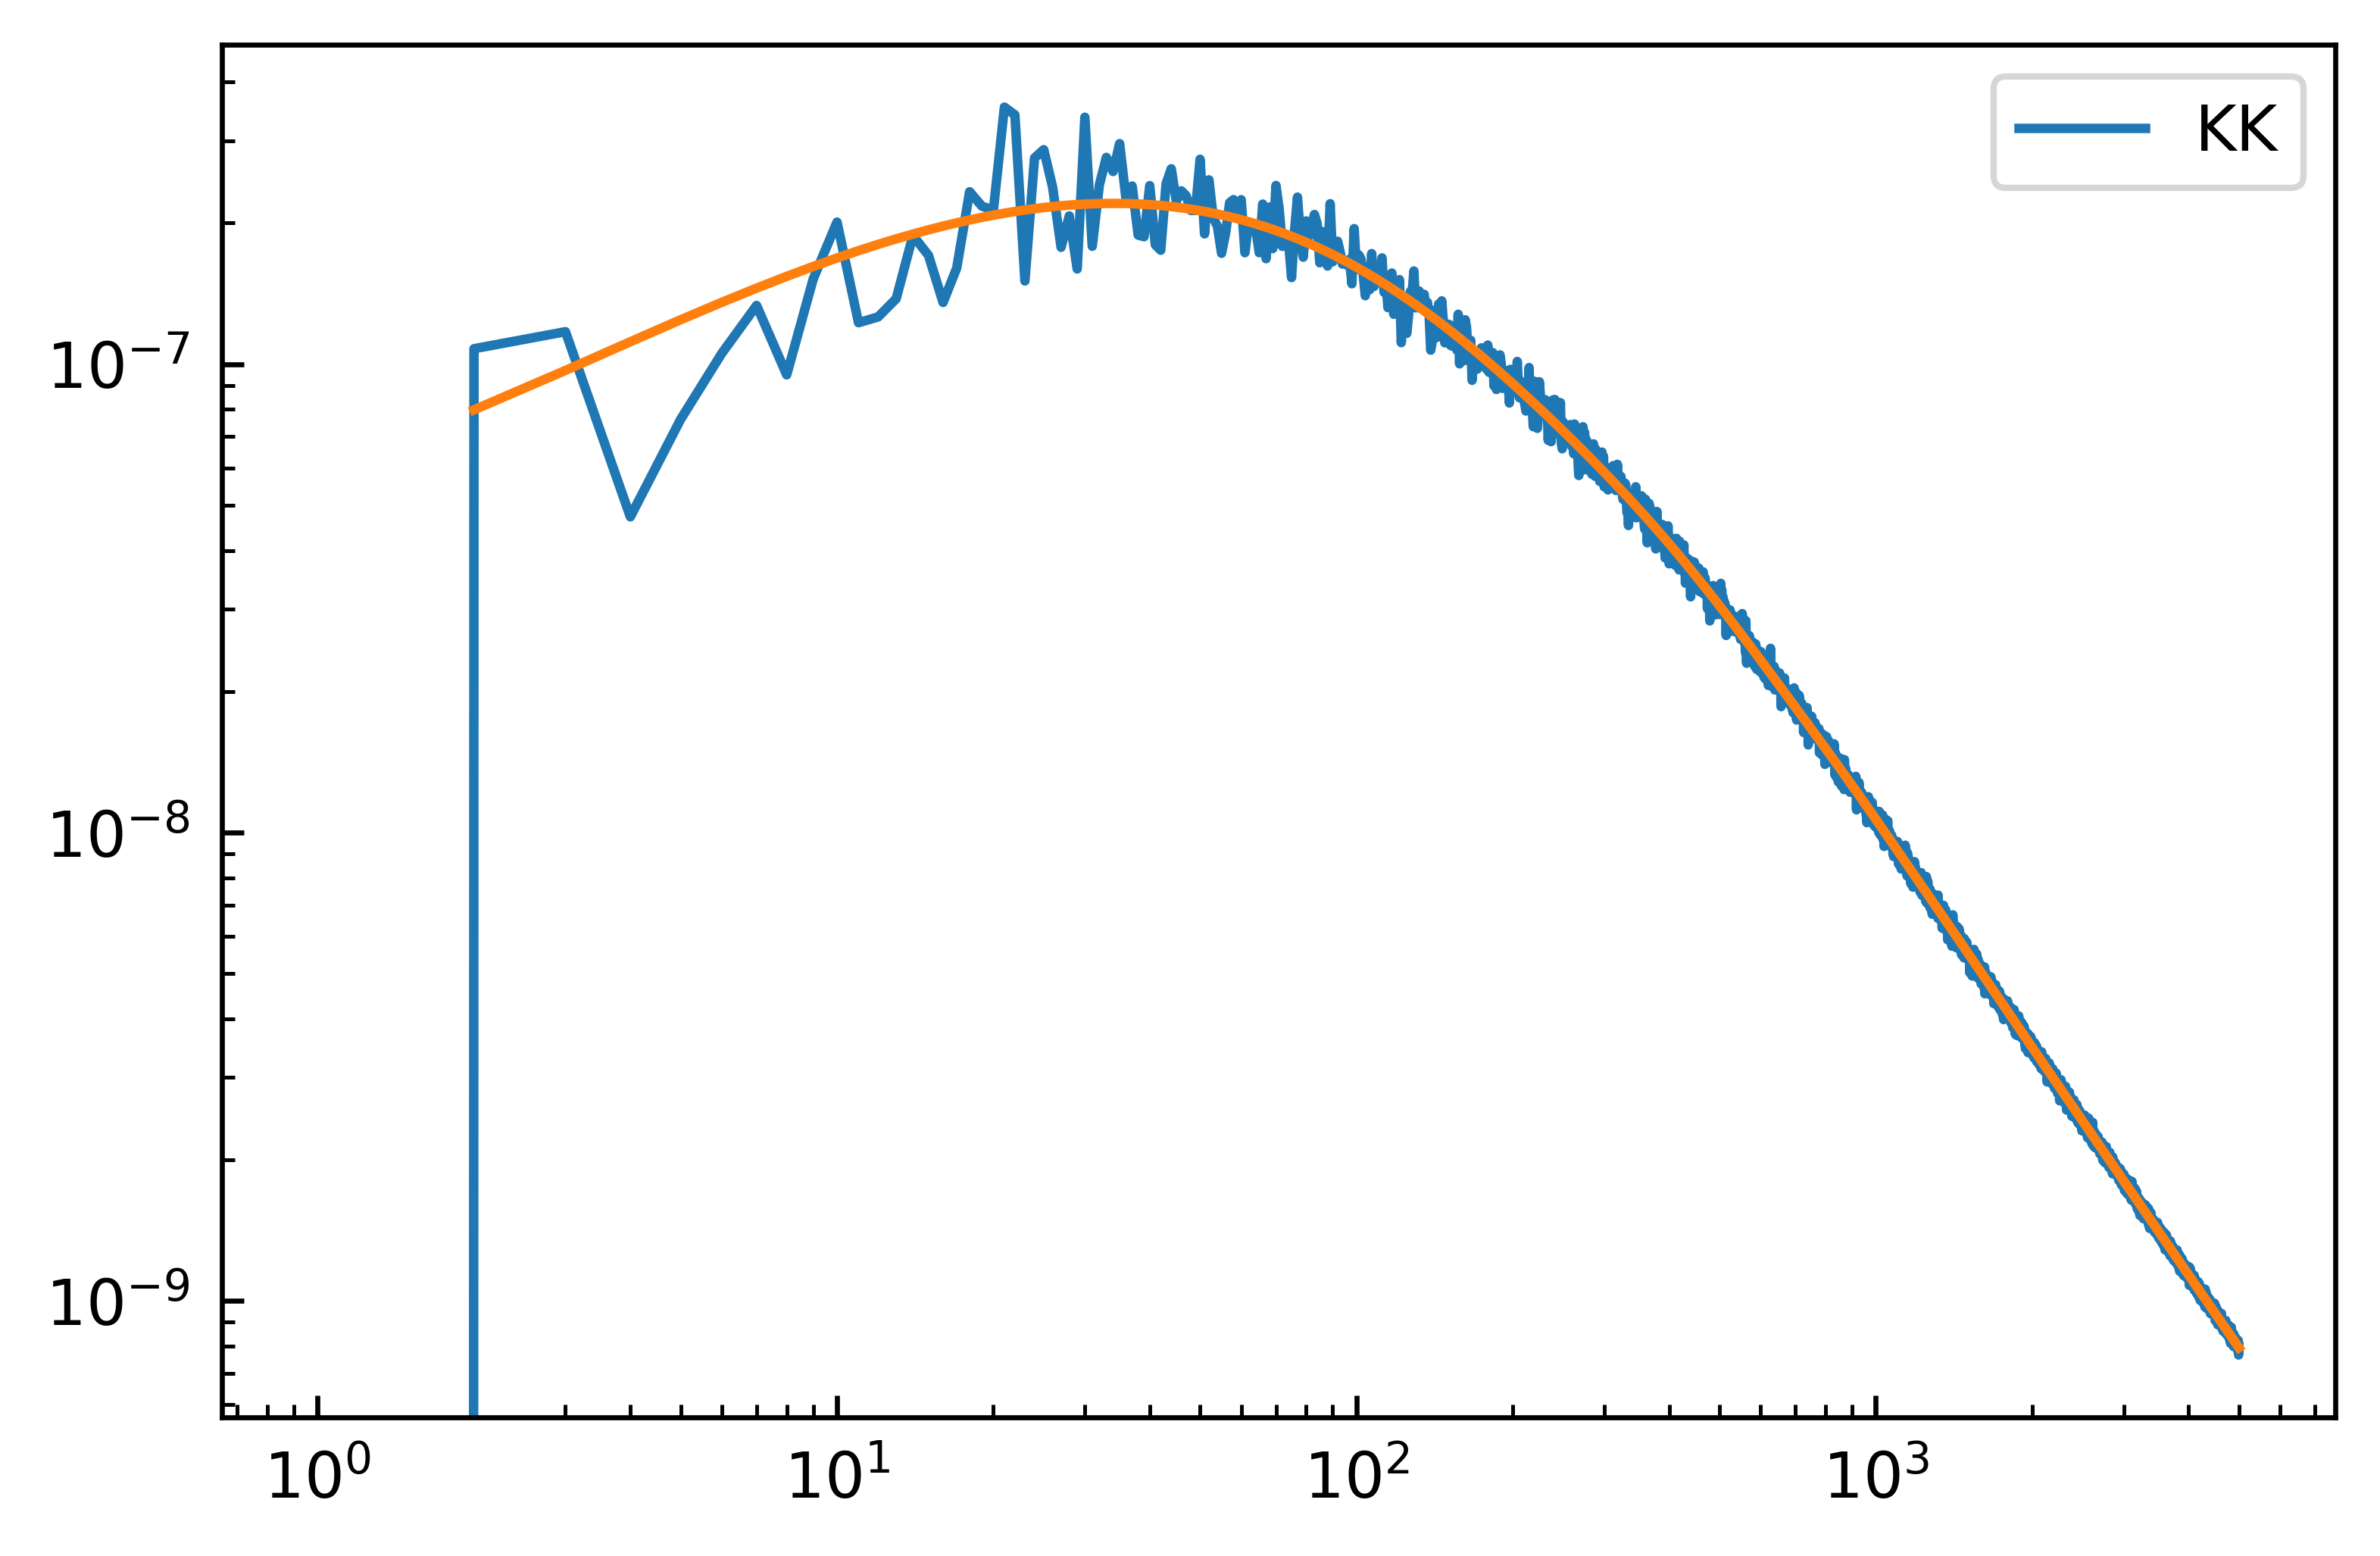

In [7]:
plt.loglog(hp.alm2cl(alms[6]),label='KK')
plt.loglog(ell,clnn[6,6])
plt.legend()

check NN cross power spectra

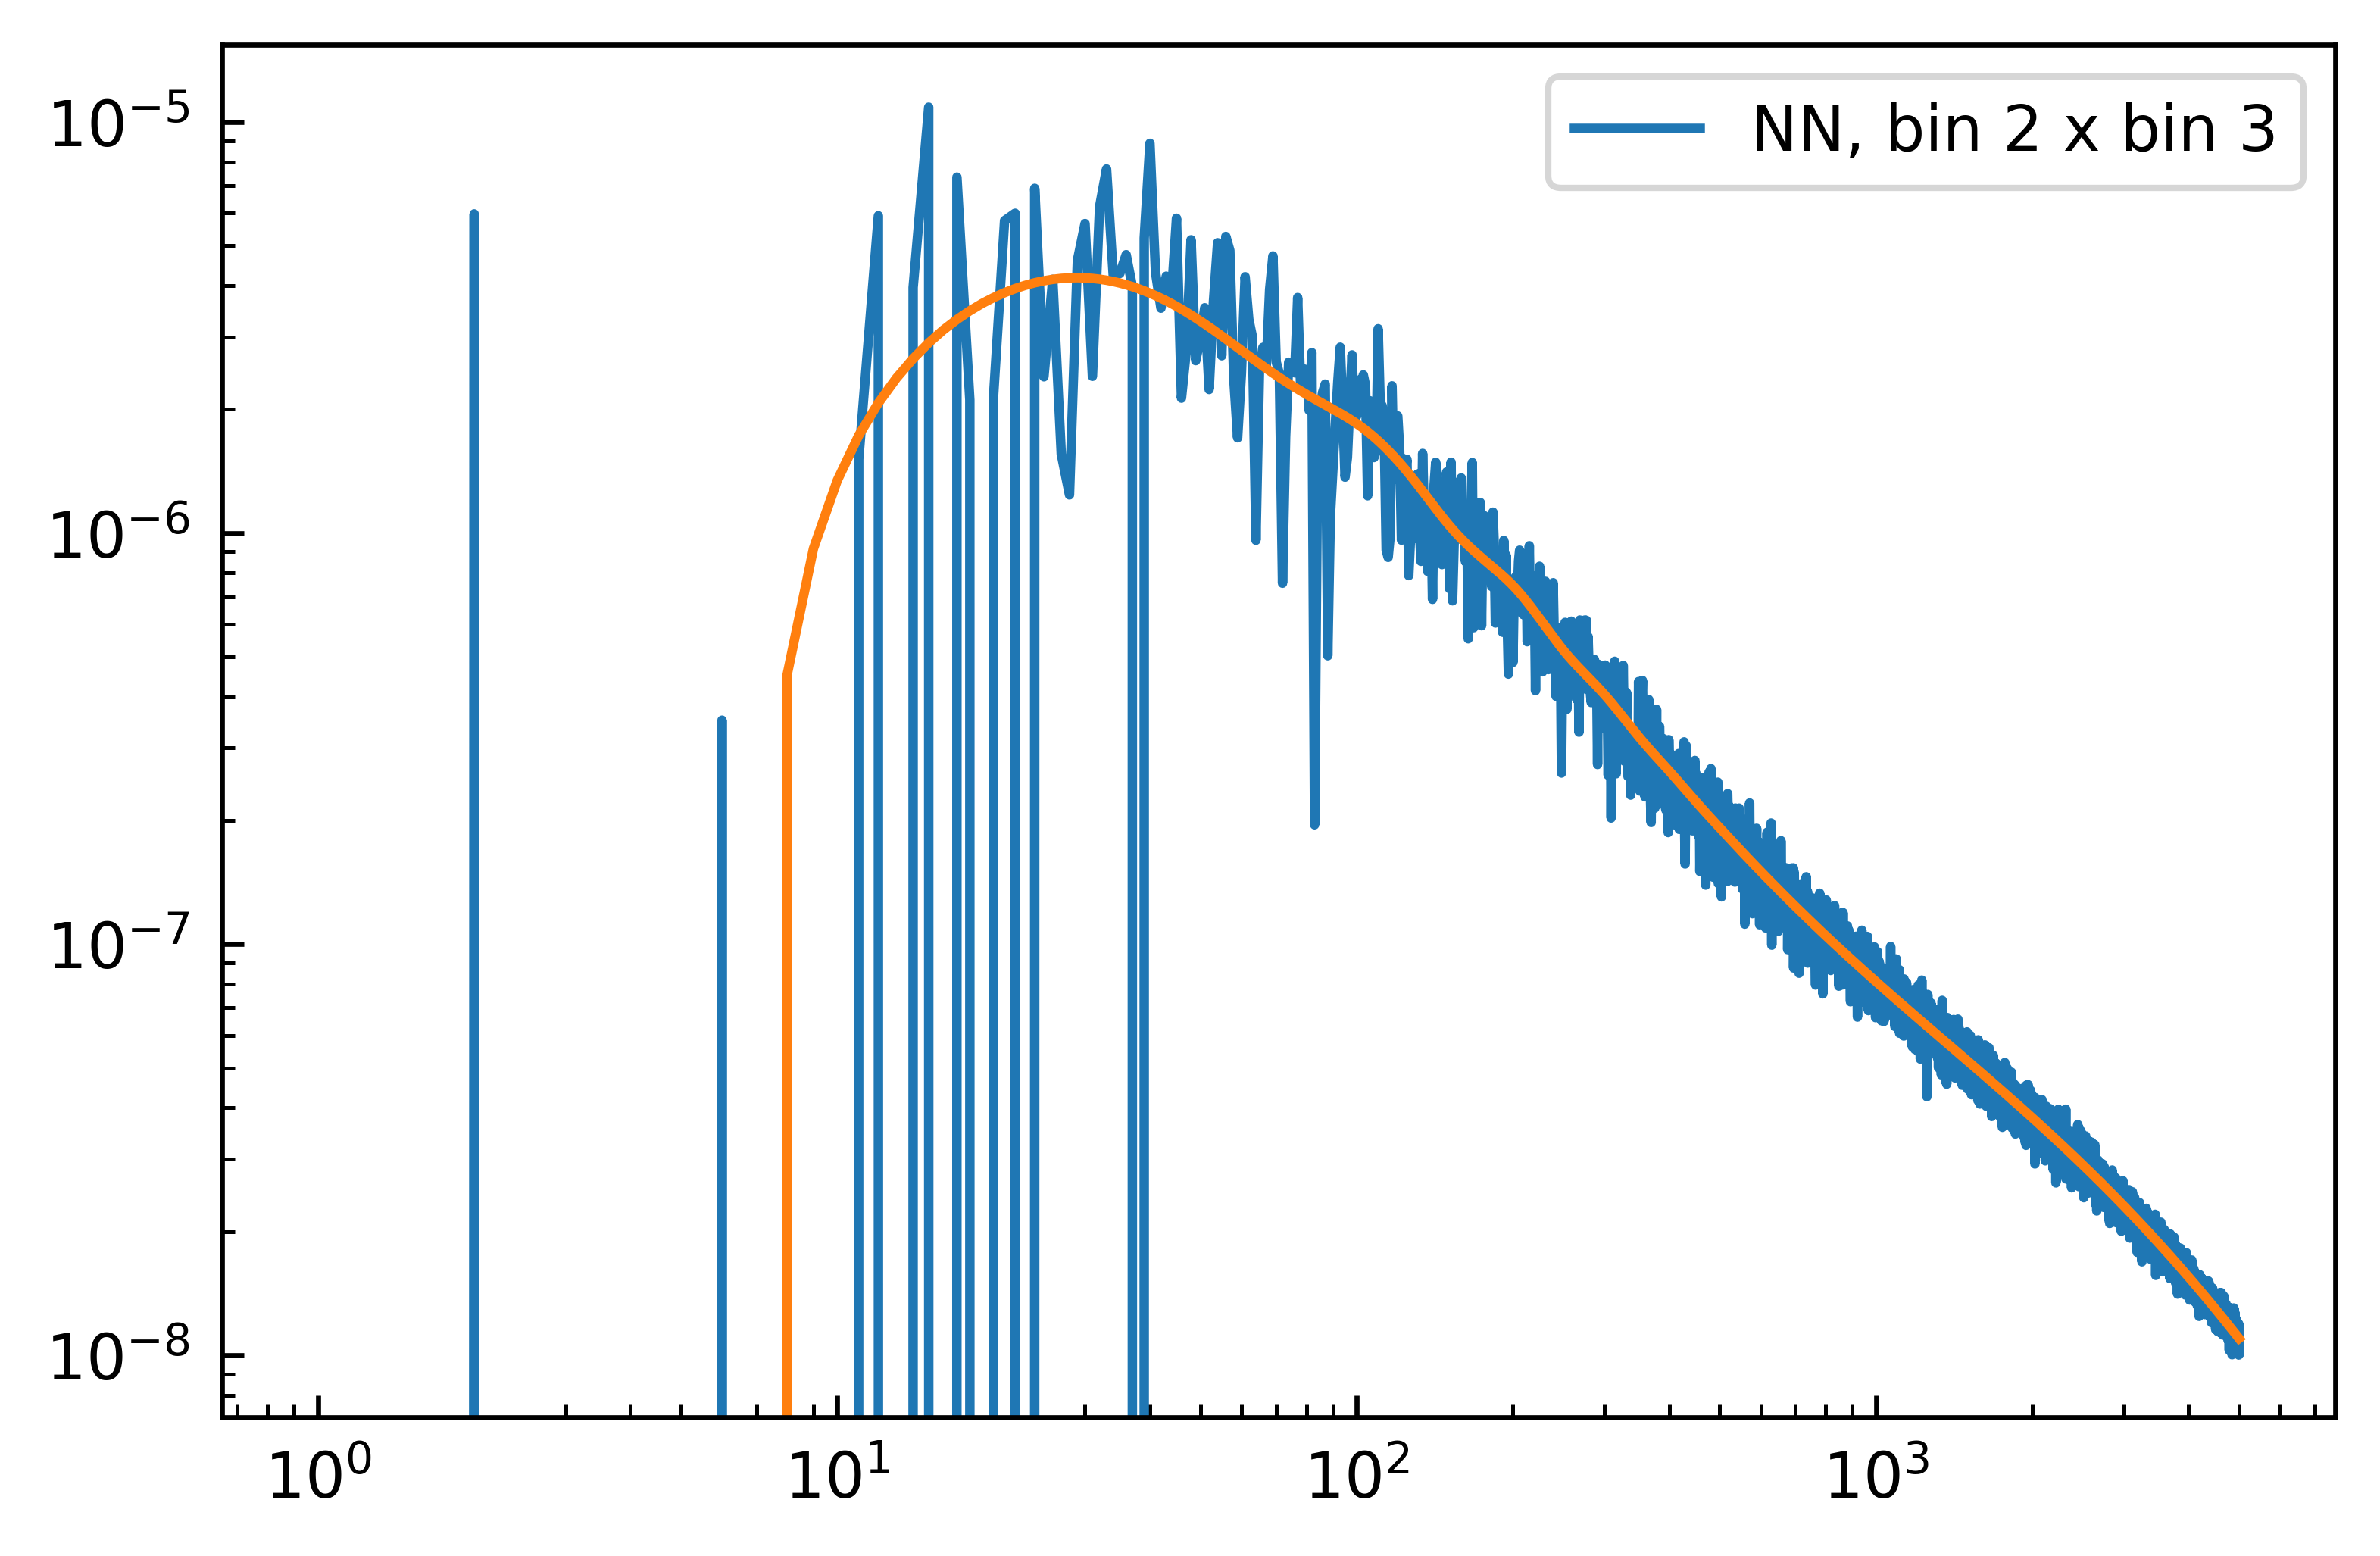

In [8]:
# check the cross power spectra NN
plt.loglog(hp.alm2cl(alms[2],alms[3]),label='NN, bin 2 x bin 3')
plt.loglog(ell,clnn[2,3])
plt.legend()

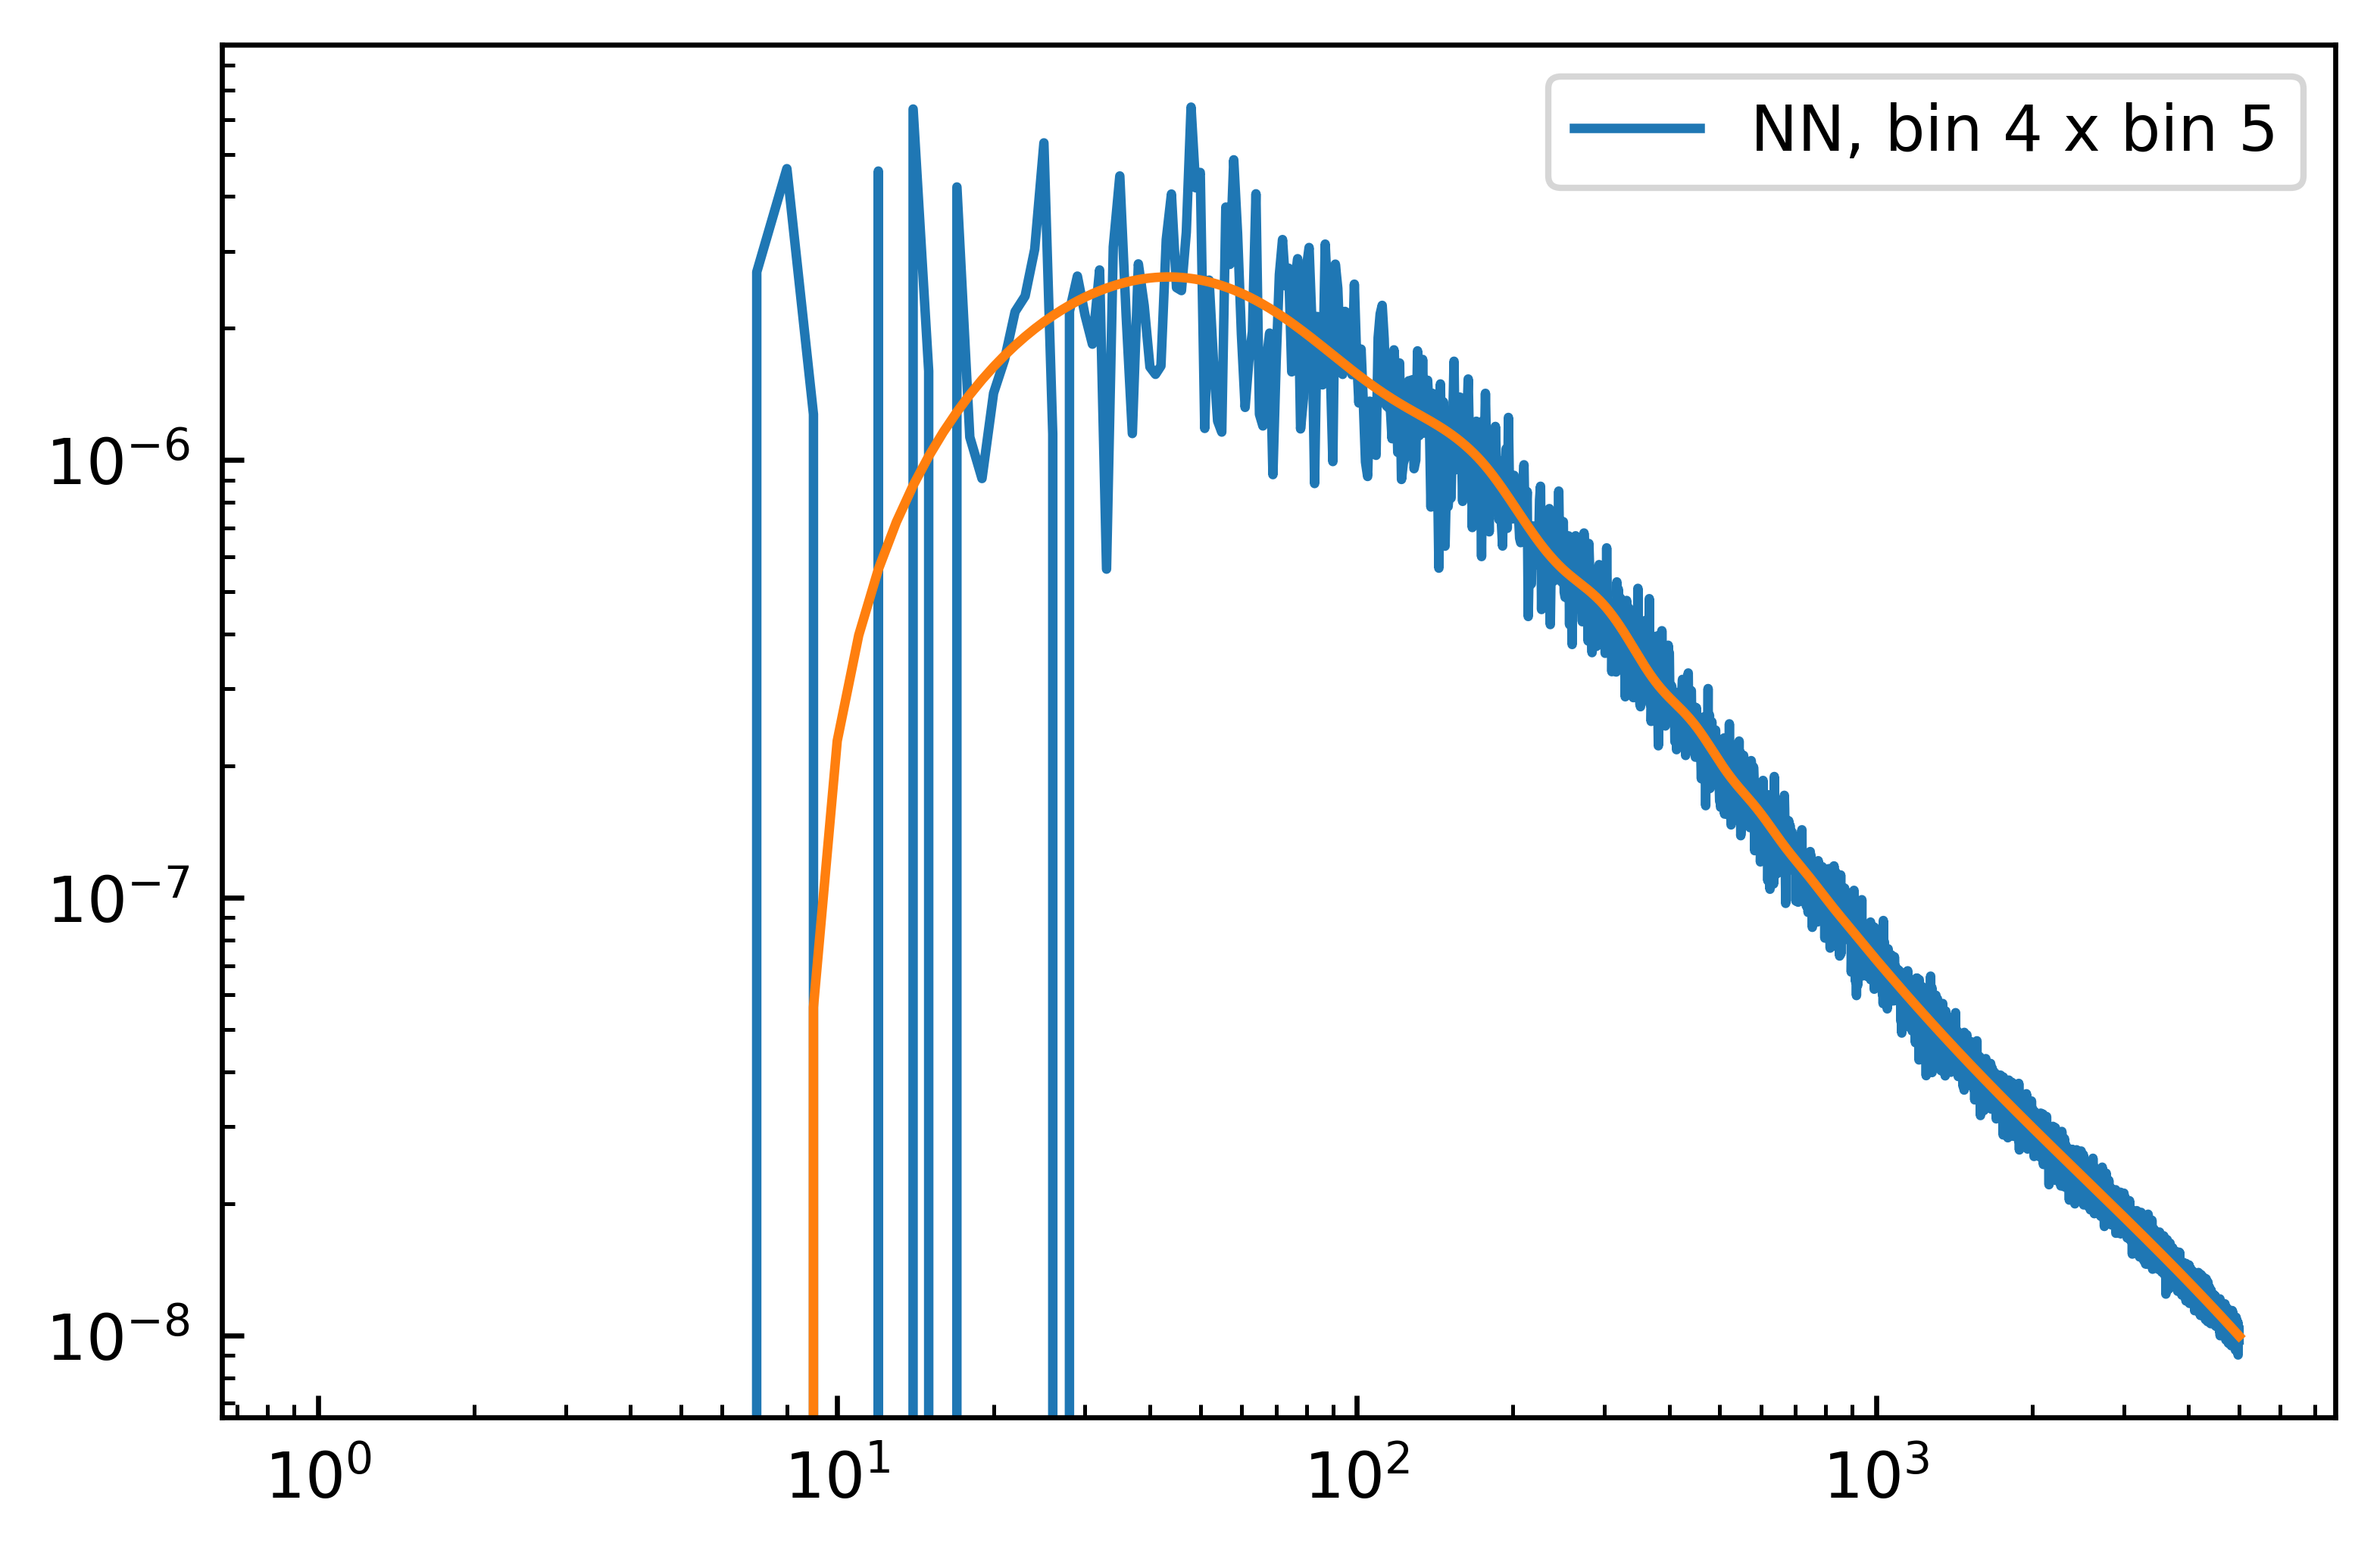

In [9]:
plt.loglog(hp.alm2cl(alms[4],alms[5]),label='NN, bin 4 x bin 5')
plt.loglog(ell,clnn[4,5])
plt.legend()

However, if we look at the power spectra between bins that are further apart, we would see something like this

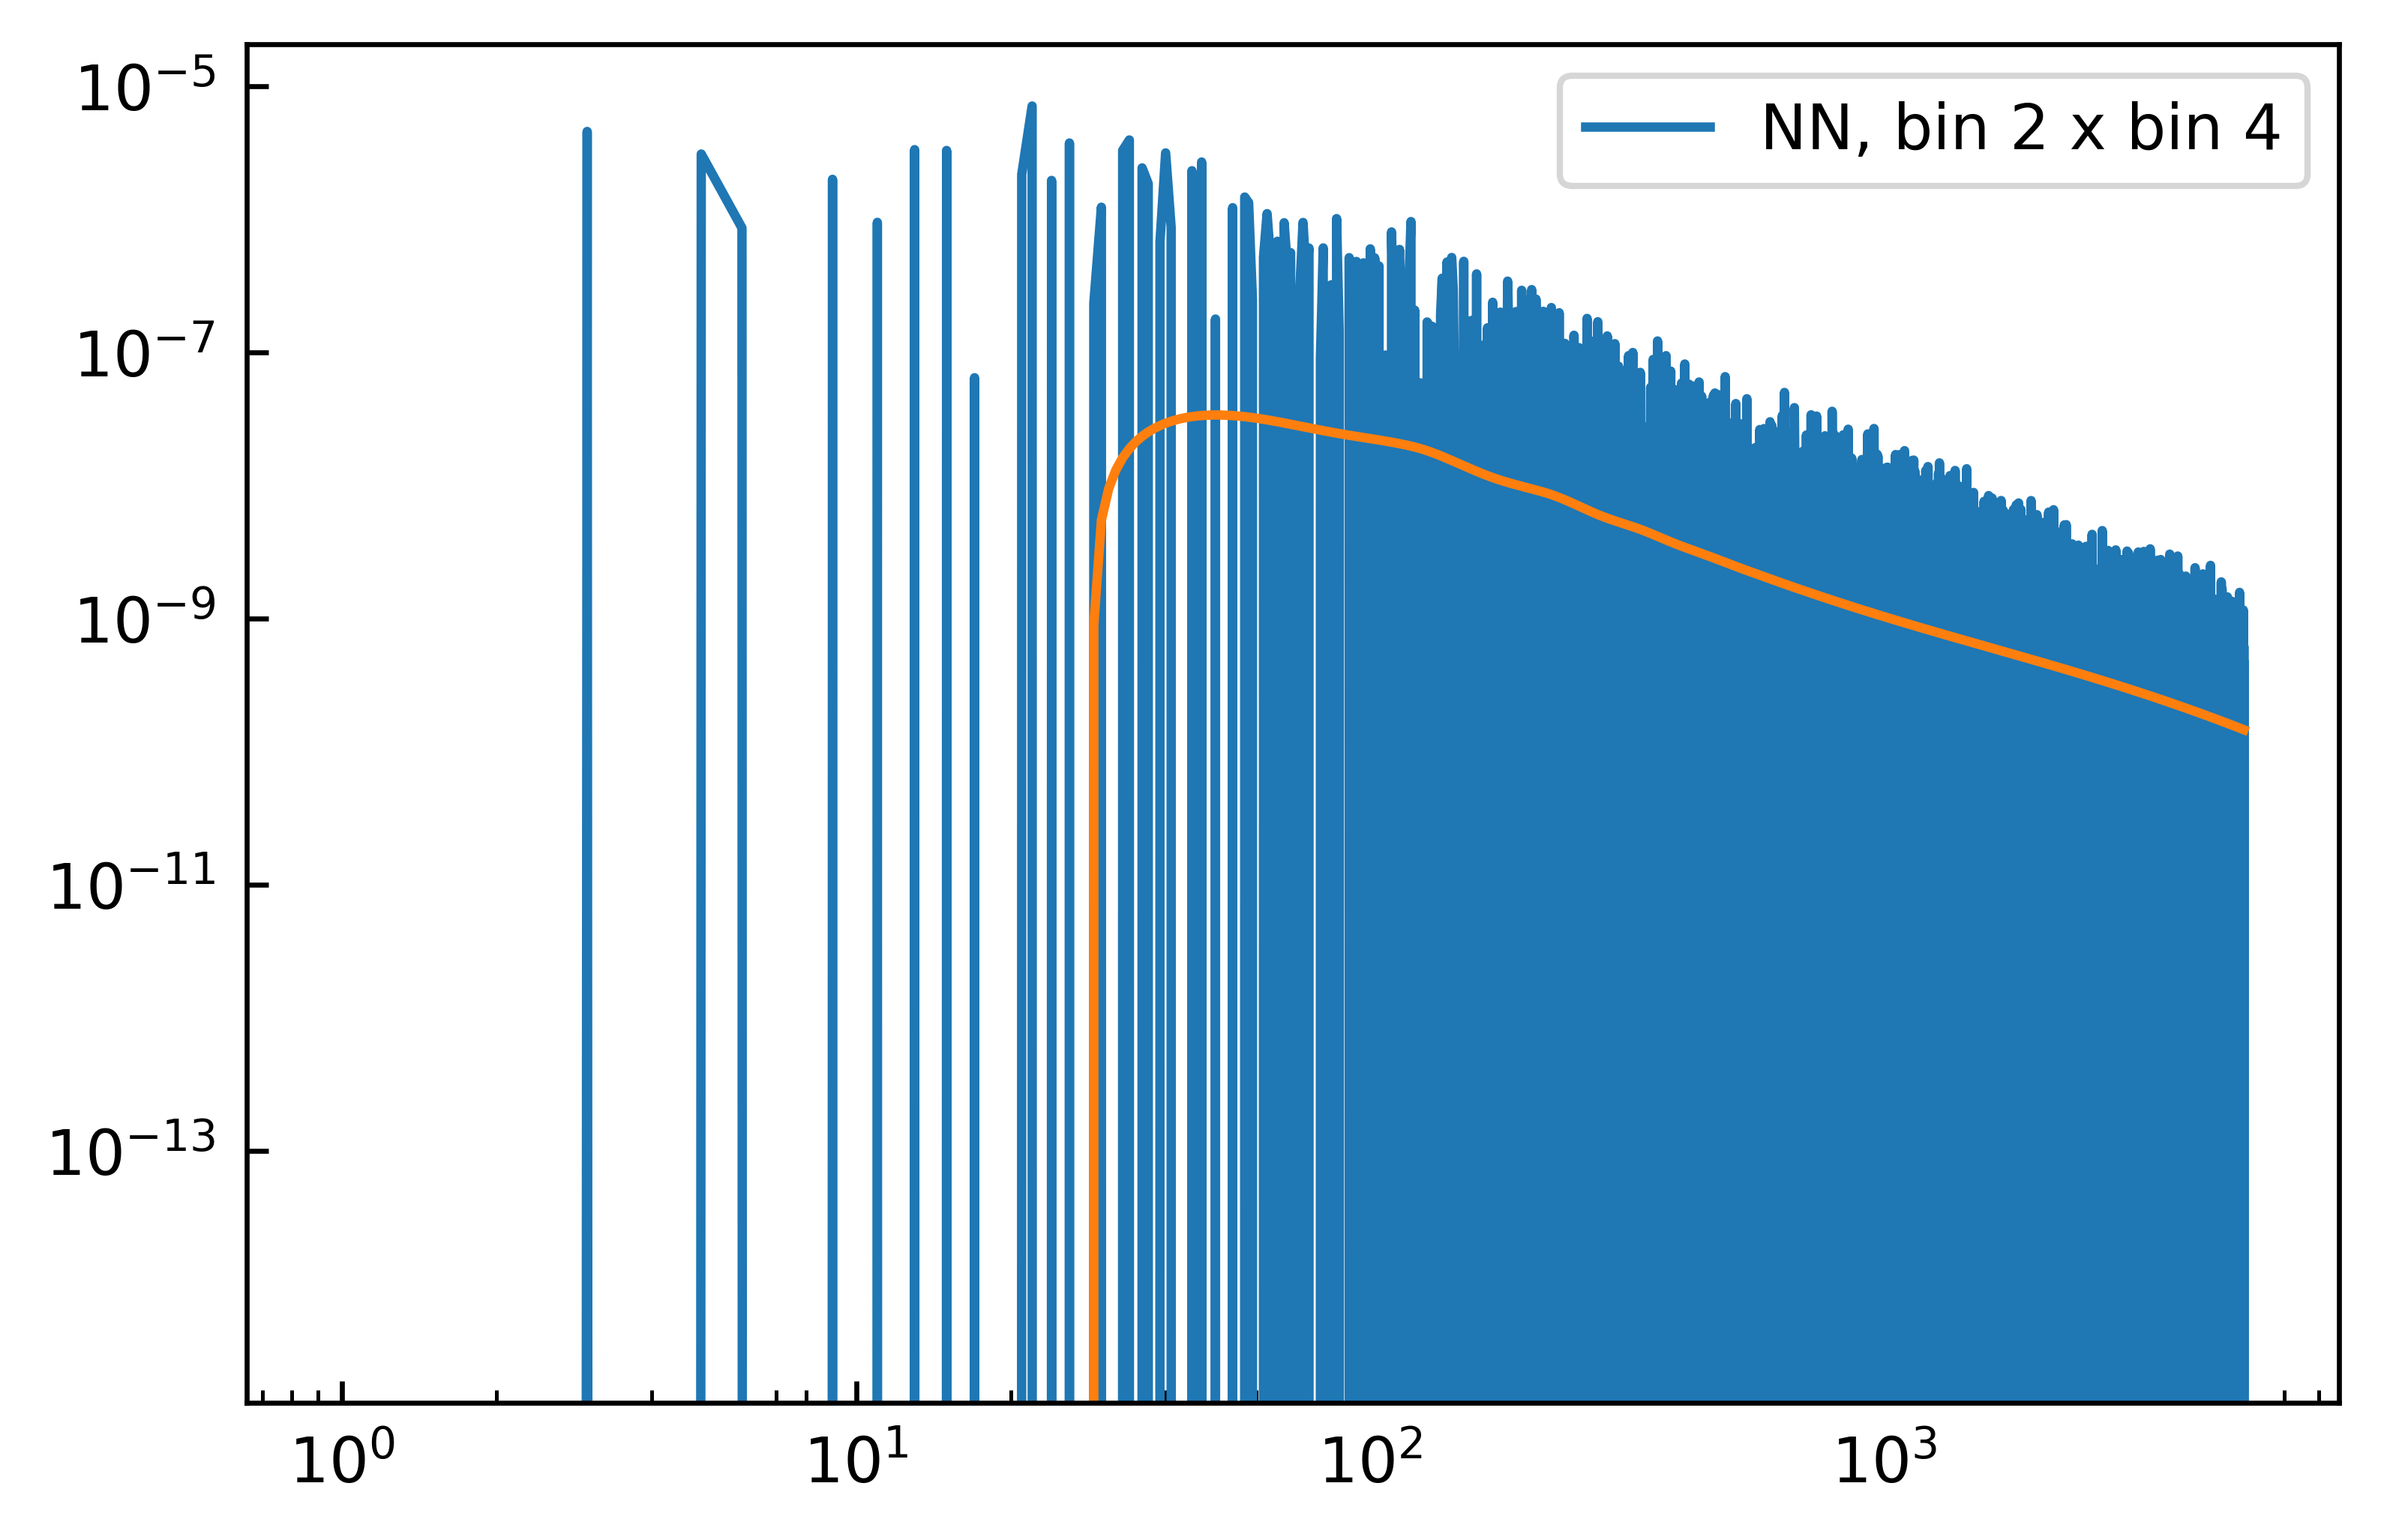

In [10]:
plt.loglog(hp.alm2cl(alms[2],alms[4]),label='NN, bin 2 x bin 4')
plt.loglog(ell,clnn[2,4])
plt.legend()

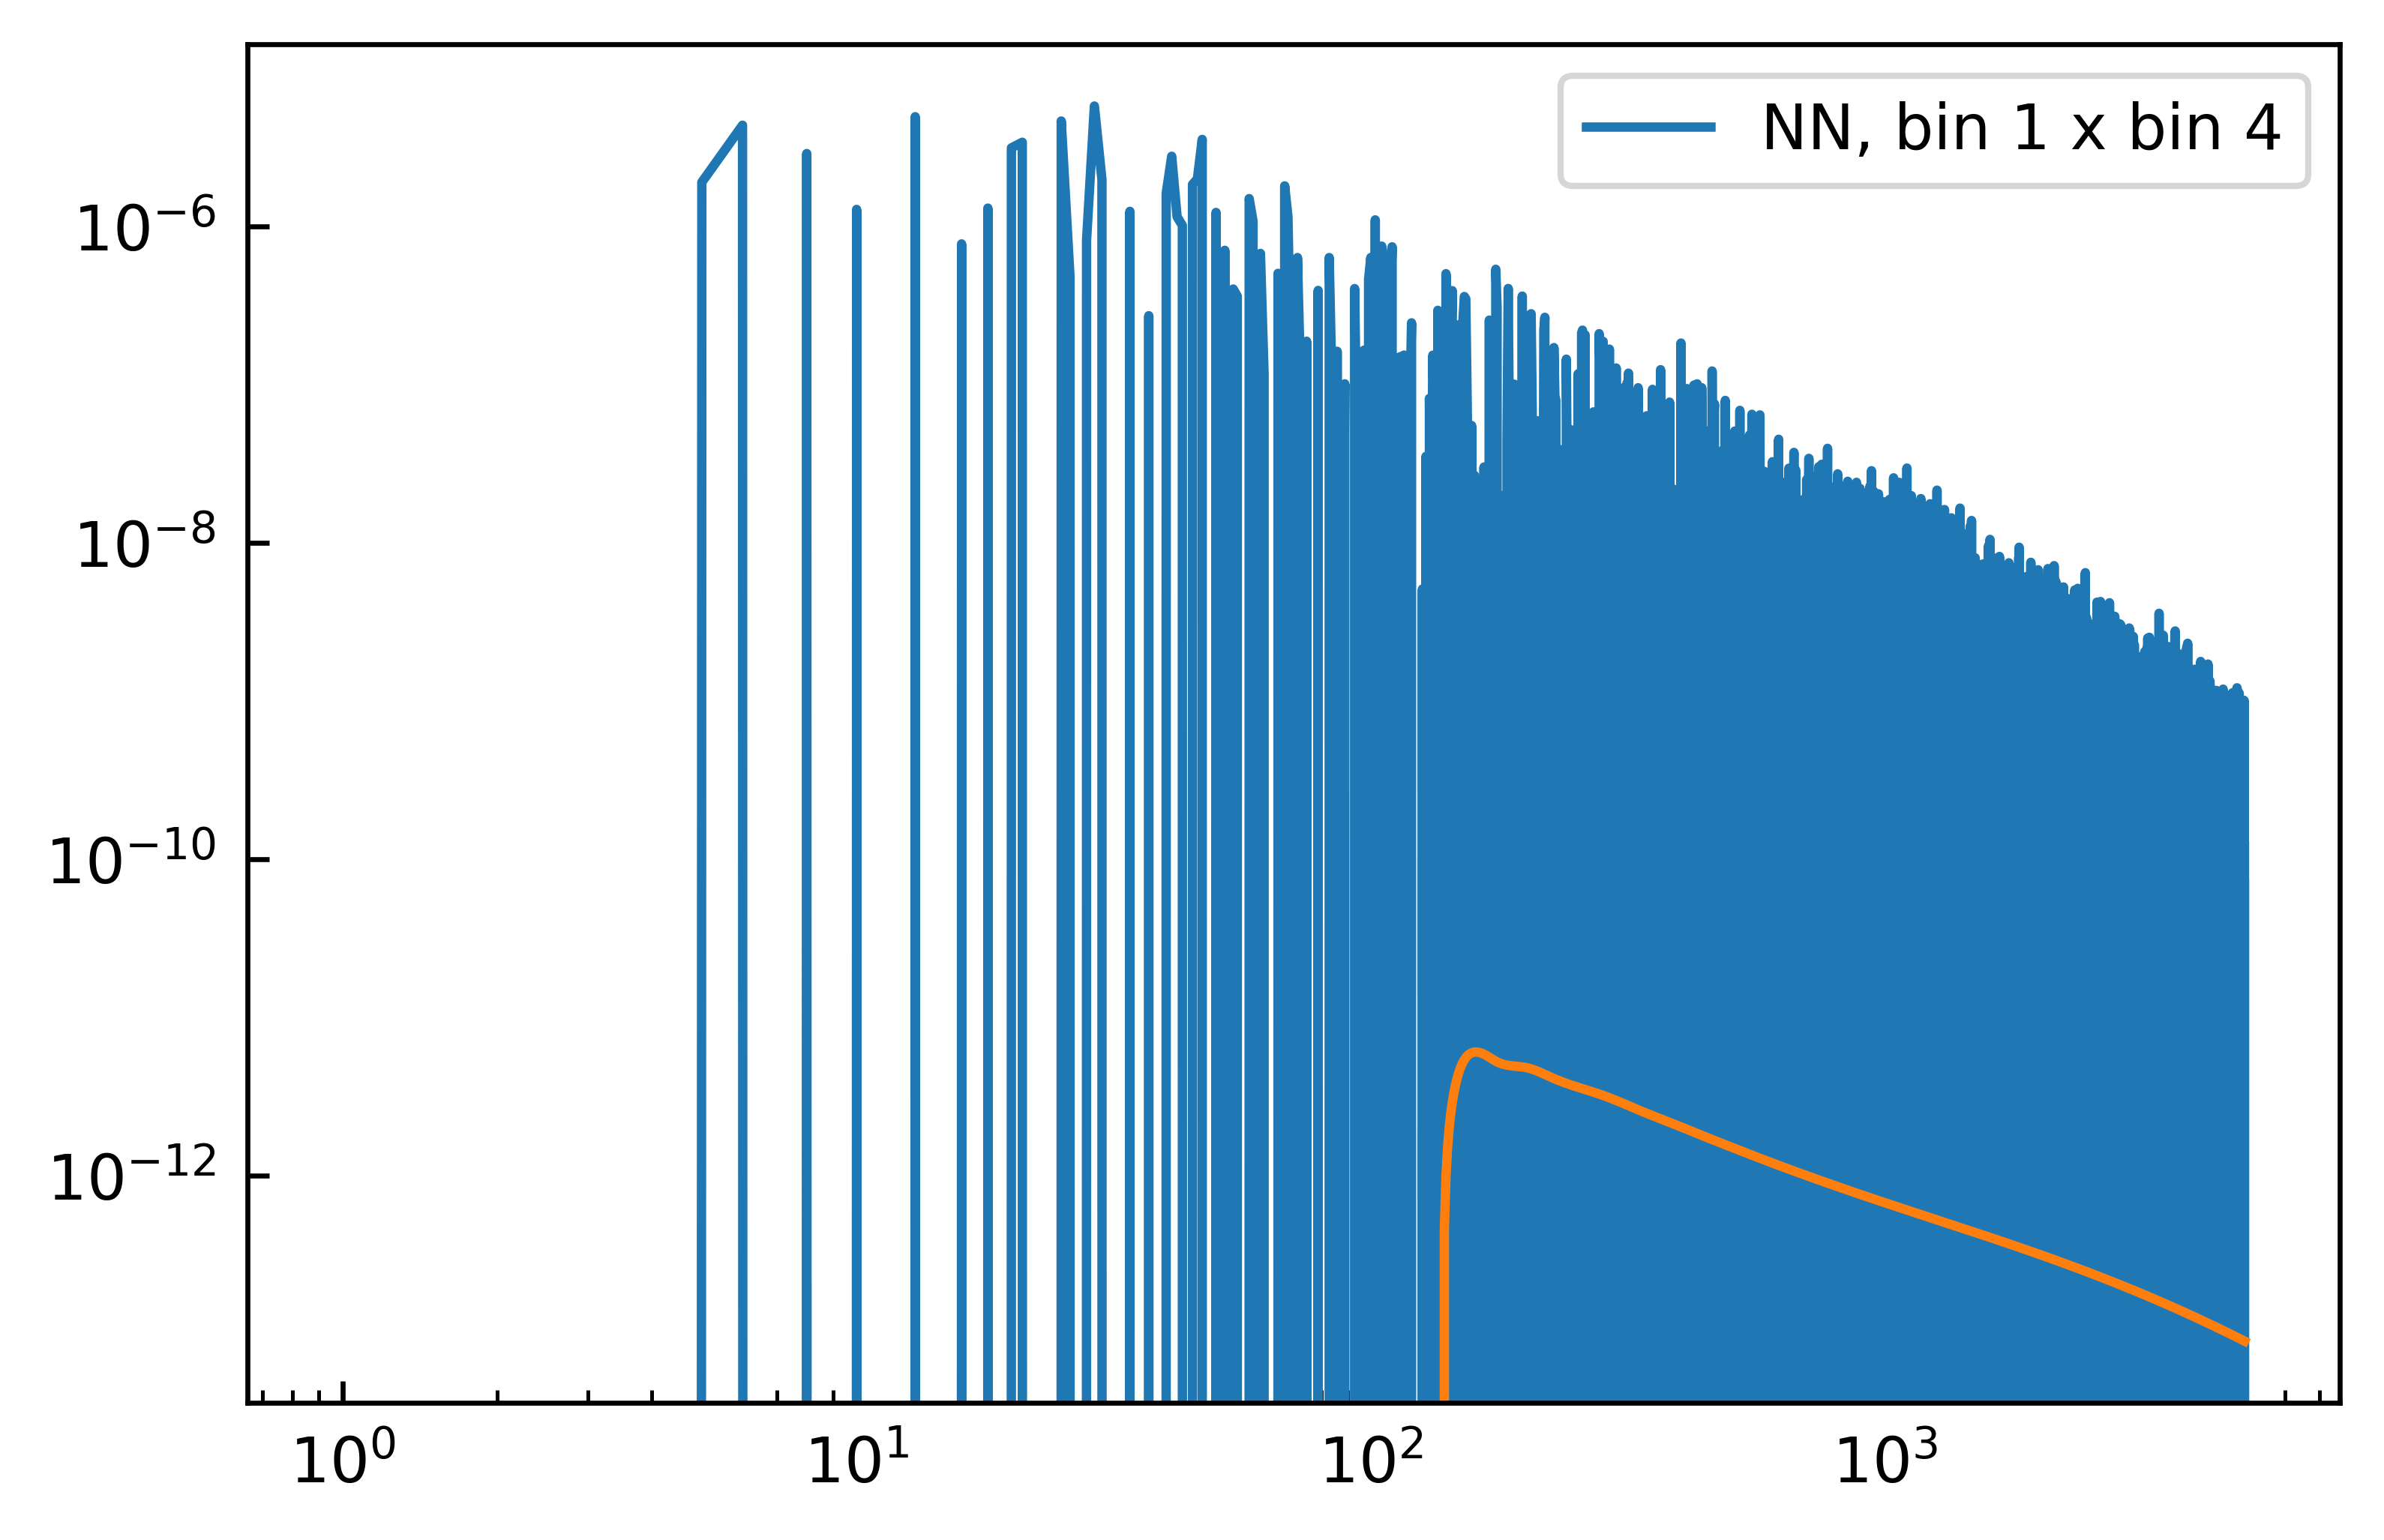

In [11]:
plt.loglog(hp.alm2cl(alms[1],alms[4]),label='NN, bin 1 x bin 4')
plt.loglog(ell,clnn[1,4])
plt.legend()

I'm not sure if it's normal to see something like this?

and these are NK power spectra, which look fine

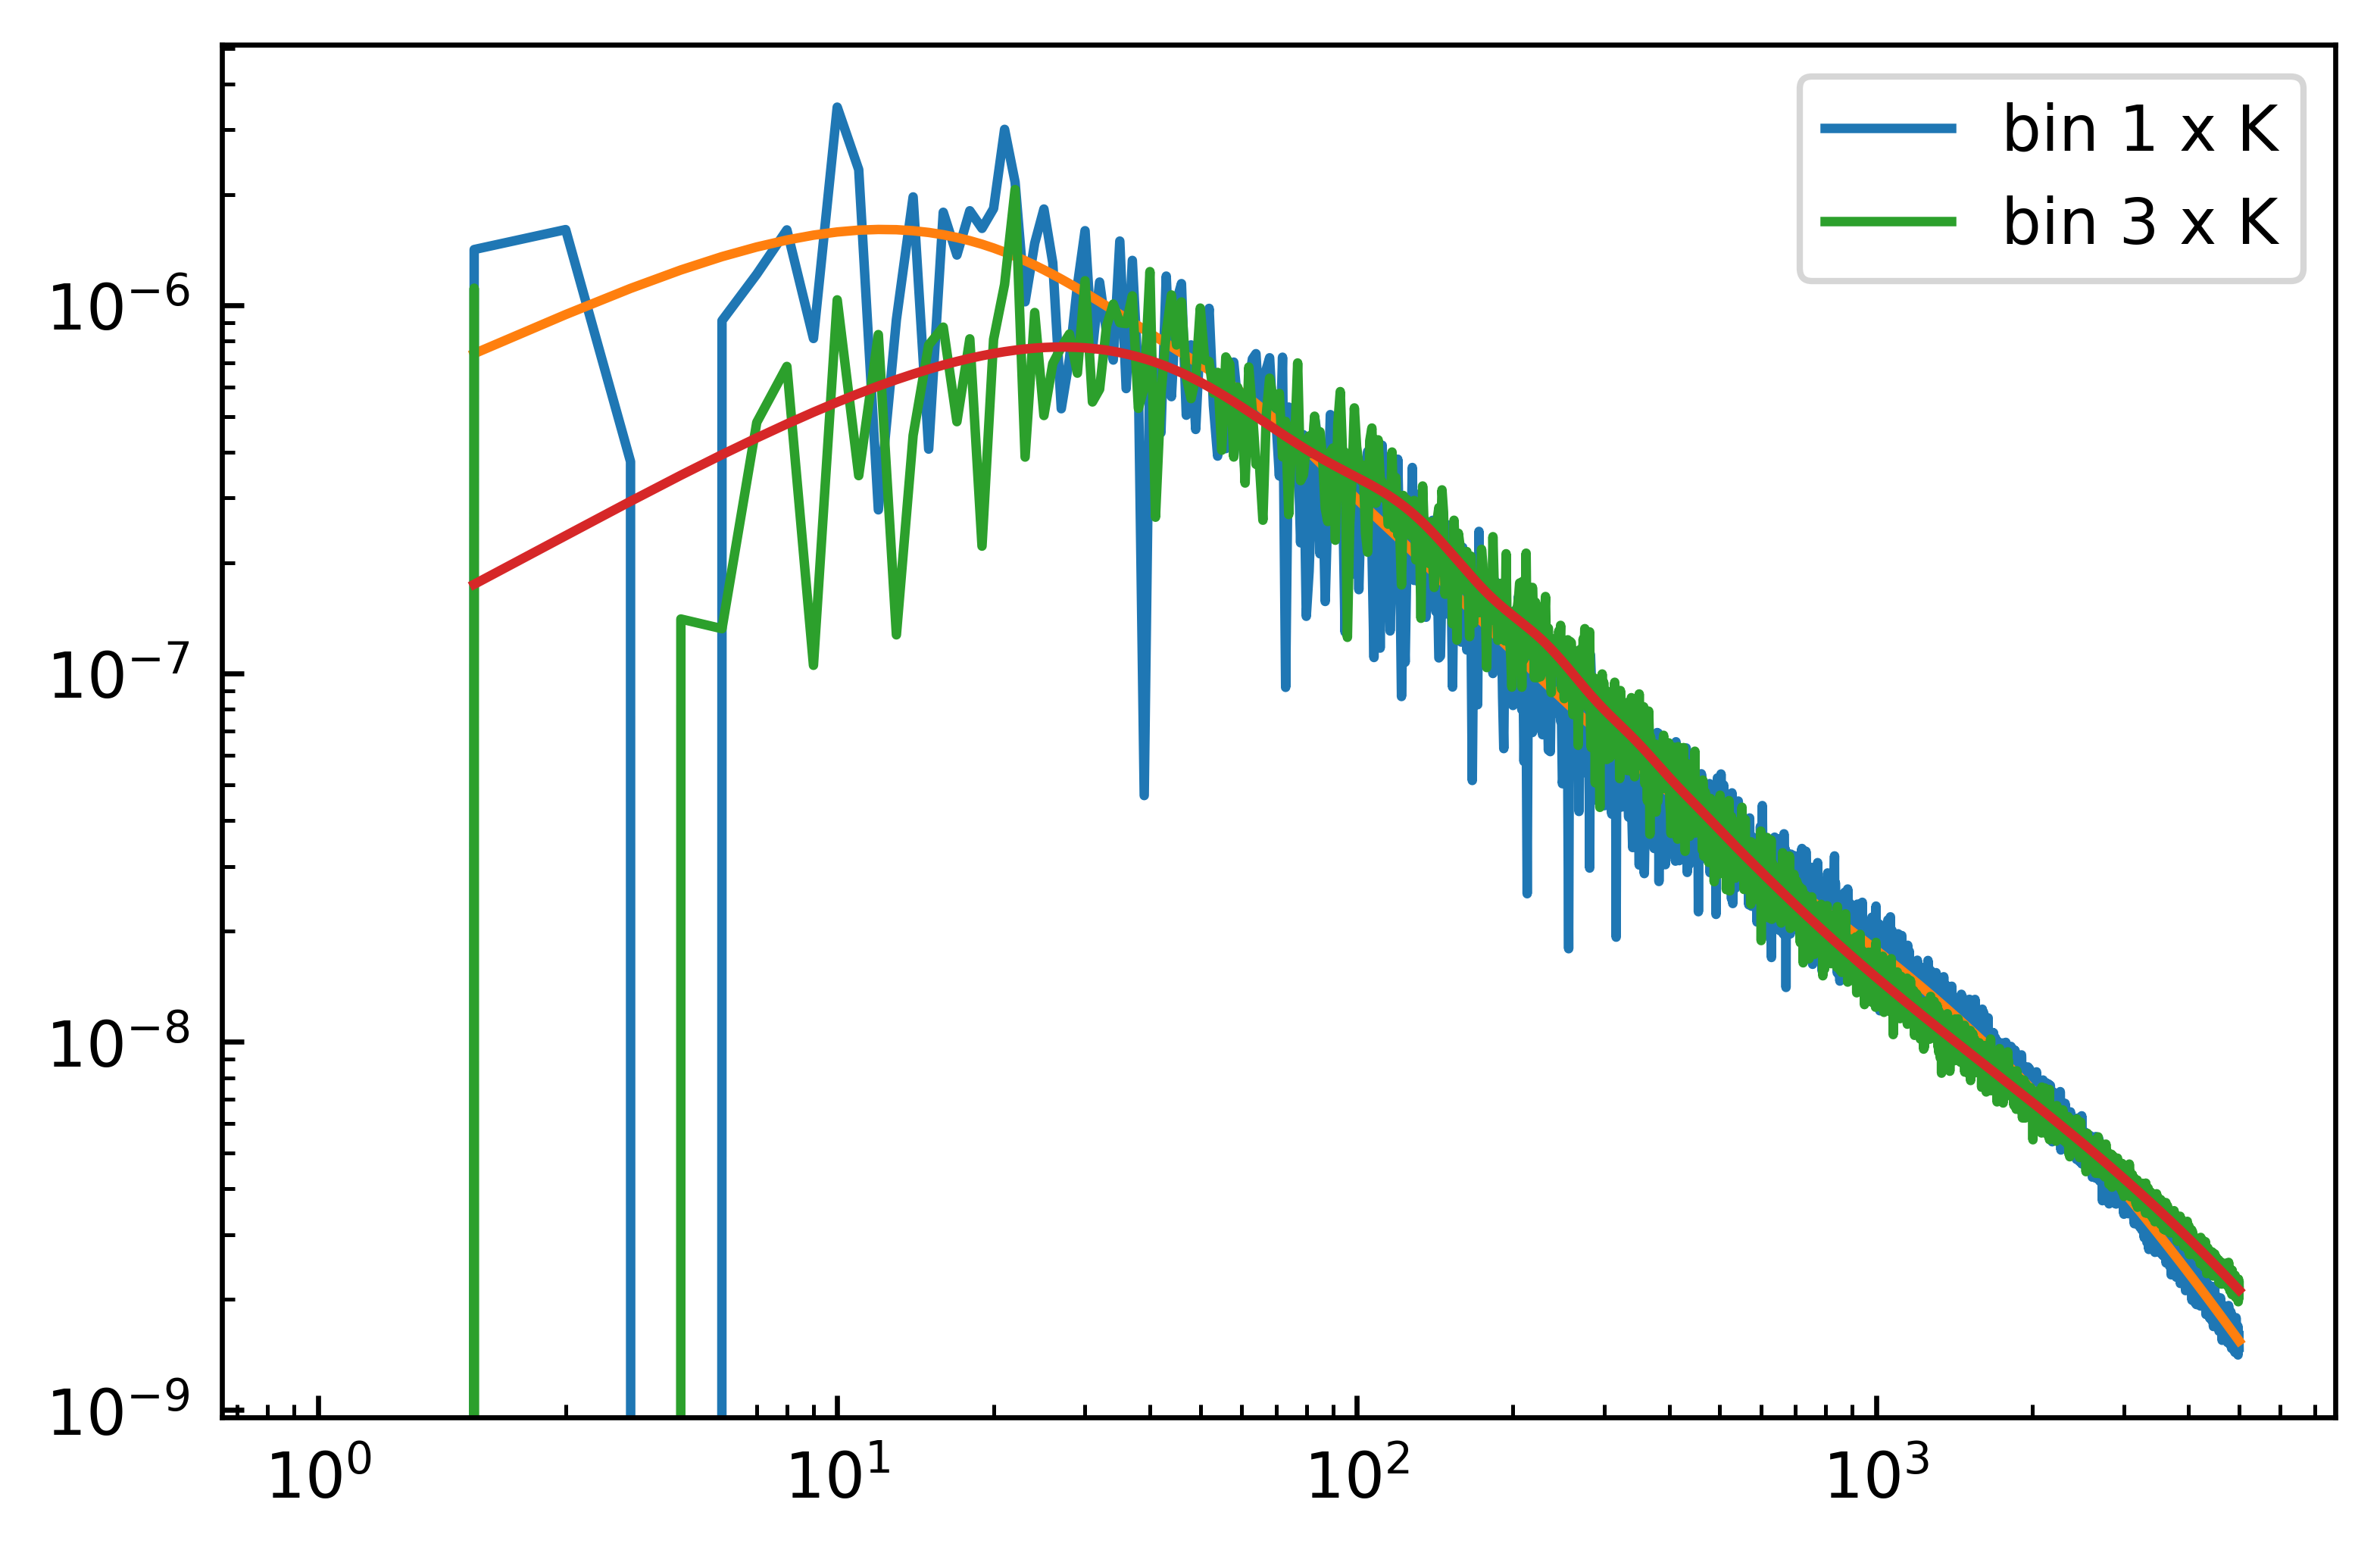

In [12]:
# NK
plt.loglog(hp.alm2cl(alms[1],alms[6]),label='bin 1 x K')
plt.loglog(ell,clnn[1,6])

plt.loglog(hp.alm2cl(alms[3],alms[6]),label='bin 3 x K')
plt.loglog(ell,clnn[3,6])
plt.legend()